In [1]:
import torch
import wandb
import os

from bayesian.models import TorchModel, BayesianModel, HorseshoeSSVS
from bayesian.inference import inference
from bayesian.utils import plot_forecast
from ESN.utils import run_esn

import pyro

c:\Users\mgphy\anaconda3\envs\uncertainty\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config = {
            "dataset": "acea",
            "model_widths": [50, 10, 1],
            "activation": "tanh",
            "distributions": ["gauss", "unif", "gauss"],
            "parameters": [[0,1],[0,10]],
            "dim_reduction": False,
            "inference": "mcmc",
            "lr": 0.03,
            "num_iterations": 120,
            "plot": False
            }

os.environ["WANDB_MODE"]="offline"
wandb.init(project="bayes_rc", config=config)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]='0'

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

Run ESN on dataset and produce embeddings with or without dimensionality reduction according to `dim_reduction`

In [4]:
Ytr, train_embedding, val_embedding, Yte, test_embedding = run_esn(config.dataset, device, dim_reduction=config.dim_reduction)

Tr: 4882, Val: 1047, Te: 1047


# Stochastic Search Variable Selection


Perform SSVS on embeddings with no dimensionality reduction.

In [ ]:
# Define the horseshoe SSVS model
# type = 'm' for 'manual' linear layer, type = 't' for torch.nn.linear
ssvs_model = HorseshoeSSVS(train_embedding.shape[1], 1, type='m', device=device)

pyro.render_model(ssvs_model, model_args=(train_embedding[0], Ytr[0]), render_distributions=True, filename=None)

In [6]:
# Run Markov chains and collect diagnostics
num_samples = 1000
ssvs_mcmc, predictive, diagnostics = inference(config, ssvs_model, None, X_train=train_embedding, Y_train=Ytr, X_test=test_embedding, Y_test=Yte, num_samples=num_samples)

Sample: 100%|██████████| 1000/1000 [2:16:48,  8.21s/it, step size=1.22e-04, acc. prob=0.480]


MCMC run time: 139.10738854181668 minutes.
MCMC converged at 990 steps.


<Figure size 600x600 with 0 Axes>

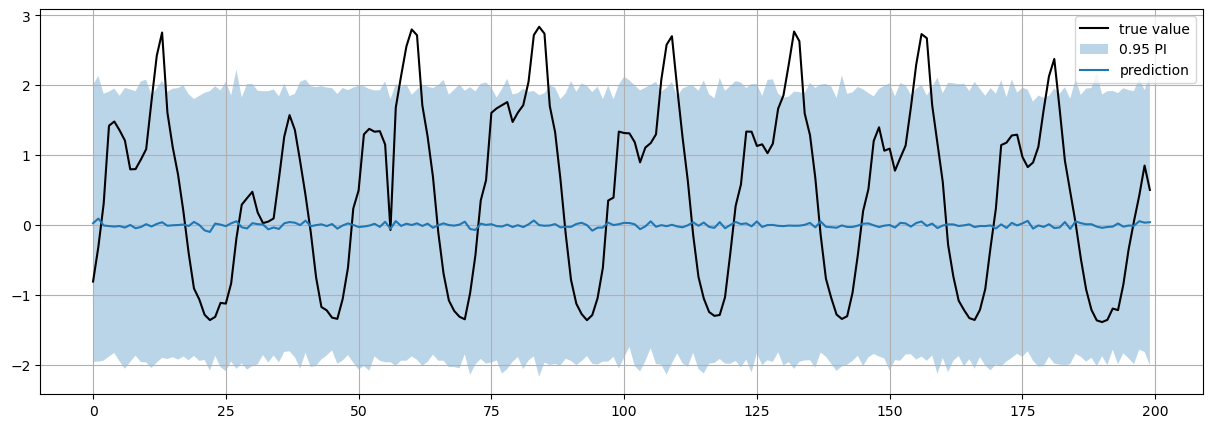

In [22]:
plot_forecast(predictive, Yte, "ssvs")

In [24]:
for k, v in diagnostics.items():
    print(k)

step_size
acceptance_rate
train_time
effective_sample_size
split_gelman_rubin
autocorrelation
cal_error


In [28]:
print("training time: ", diagnostics['train_time'])
print("effective sample size: ", diagnostics['effective_sample_size'])
print("calibration error: ", diagnostics['cal_error'])

training time:  8346.443312509
effective sample size:  tensor(4.4015, device='cuda:0')
calibration error:  10.500617028085884


In [21]:
# to reload a package or method
import sys, importlib

importlib.reload(sys.modules['bayesian.utils'])

from bayesian.utils import plot_forecast

In [23]:
# to save a session
import dill

dill.dump_session('dump/notebook_16122022.db')

In [ ]:
# to load a session
dill.load_session('notebook_env.db')

# SVI

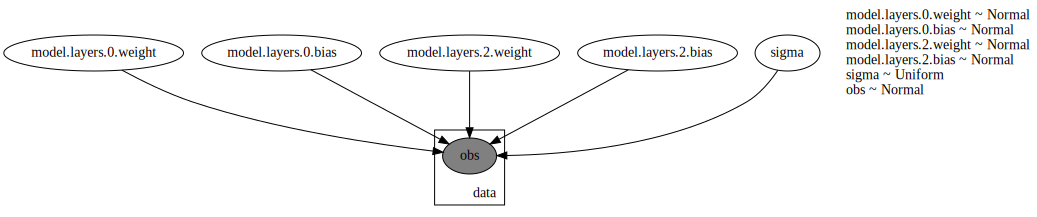

In [6]:
torch_model = TorchModel(config.model_widths, config.activation).to(device)
svi_model = BayesianModel(torch_model, config, device)
svi_model.render_model(model_args=(train_embedding[0], Ytr[0]))

Autoguide for testing

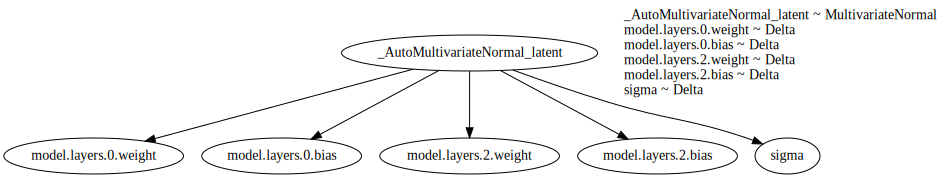

In [7]:
from pyro.infer.autoguide import AutoMultivariateNormal, init_to_mean

# To enforce all the parameters in the guide on the GPU, since we use an autoguide
if device != 'cpu':
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

guide = AutoMultivariateNormal(svi_model, init_loc_fn=init_to_mean)
pyro.render_model(guide, model_args=(train_embedding, Ytr), render_distributions=True)